In [16]:
import gym
from gym import spaces
import numpy as np
import math
import matplotlib.pyplot as plt

In [17]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [18]:
space = spaces.MultiBinary(3)
print([space.sample() for _ in range(5)])

[array([0, 0, 0], dtype=int8), array([1, 1, 0], dtype=int8), array([0, 1, 1], dtype=int8), array([1, 1, 0], dtype=int8), array([0, 1, 1], dtype=int8)]


In [30]:
class MigraineEnv(gym.Env):
    def __init__(self, num_triggers: int = 2, horizon: int = 20):
        self.num_triggers = num_triggers
        self.horizon = horizon
        self.timestep = 0
        self.observation_space = spaces.Box(low=0, high=7, shape=(1,), dtype=np.float32)  # Continuous score from 0 to 7
        self.action_space = spaces.Box(low=0, high=1, shape=(num_triggers,), dtype=np.float32)  # Continuous actions
        self.state = np.array([self.observation_space.sample()])
        self.h_j = 0.5  # equal probability for any specific migraine trigger
        self.history = np.zeros((horizon, num_triggers))  # history of actions
        self.y_min = 0.5
        self.K_plus = max(1.333, 0)
        self.K_minus = min(-1, 0)

    def reset(self):
        self.state = np.array([self.observation_space.sample()])
        self.timestep = 0
        self.history = np.zeros((self.horizon, self.num_triggers))
        return self.state

    def step(self, action: np.array):
        # Apply the integral control law to adjust the action
        action = self.integral_control_law(action, self.state[0])
        self.history[self.timestep] = action
        y_nat = np.random.normal(0, 1)  # Sample from N(0, 1)
        y_next = self.calculate_wellness(action, y_nat)
        self.state = np.array([y_next])  # Continuous state based on y_next
        self.timestep += 1
        done = self.timestep >= self.horizon
        reward = -self.state[0]  # Reward is negative of the state (minimize migraines)
        return self.state, reward, done, {}  # Return the continuous state

    def calculate_wellness(self, action, y_nat):
        # Calculate the wellness of the next state using the provided system model
        y_next = y_nat
        for j in range(self.num_triggers):
            for k in range(self.timestep + 1):
                y_next += self.h_j * self.history[self.timestep - k, j]
        y_next = np.clip(y_next, 0, 7)  # Ensure y_next is within the range [0, 7]
        return y_next

    def integral_control_law(self, action, y_t):
        # Apply the integral control law to find the minimum u_j for each migraine trigger
        new_action = np.zeros_like(action)
        for j in range(self.num_triggers):
            u_j_prev = action[j] if self.timestep > 0 else 0
            new_action[j] = max(0, u_j_prev - self.K_plus * (y_t - self.y_min) - self.K_minus * (y_t - self.y_min))
        return new_action

    def render(self, mode='human'):
        pass

action:  [0.05583286 0.6971565  0.20031932]
state:  [0.]
action:  [0.5815447  0.52301604 0.88784194]
state:  [0.2616195]
action:  [0.33120325 0.69386756 0.727333  ]
state:  [2.80517341]
action:  [0.33657432 0.00229272 0.35740677]
state:  [2.25964791]
action:  [0.8855352  0.1036474  0.20324463]
state:  [2.58090443]
action:  [0.17243731 0.74631673 0.11966277]
state:  [1.59636733]
action:  [0.9081341  0.376284   0.42549828]
state:  [3.44838169]
action:  [0.8792987  0.87266064 0.43668142]
state:  [2.90242065]
action:  [0.5889818  0.04242934 0.6173151 ]
state:  [1.06629644]
action:  [0.20524509 0.29216614 0.36523718]
state:  [2.19731446]
action:  [0.46630827 0.9799781  0.18245183]
state:  [3.86173508]
action:  [0.47827885 0.01331009 0.03755441]
state:  [2.8998039]
action:  [0.03632213 0.45197976 0.6148666 ]
state:  [2.65621811]
action:  [0.32061103 0.30489427 0.21856152]
state:  [2.39226801]
action:  [0.8124639  0.9353543  0.08478996]
state:  [5.04139192]
action:  [0.484093   0.42082456 0.3

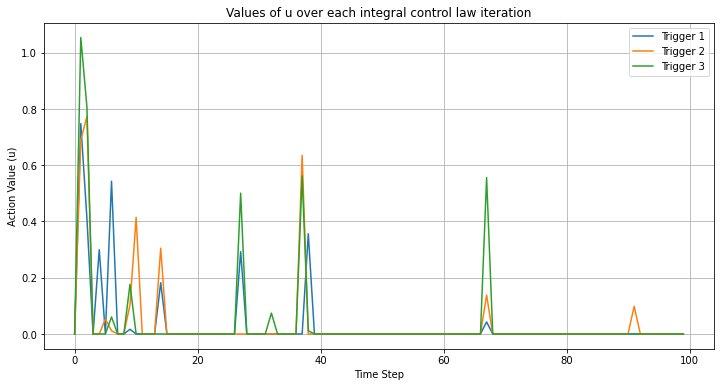

In [32]:
# Initialize the environment
env = MigraineEnv(num_triggers=3, horizon=100)

# Run the environment and store the actions
actions_history = np.zeros((env.horizon, env.num_triggers))
state = env.reset()
for t in range(env.horizon):
    action = env.action_space.sample()  # Random initial action
    state, reward, done, _ = env.step(action)
    print('action: ', action)
    print('state: ', state)
    actions_history[t] = env.history[t]

# Plot the actions for each trigger over time
plt.figure(figsize=(12, 6))
for j in range(env.num_triggers):
    plt.plot(actions_history[:, j], label=f'Trigger {j+1}')

plt.title('Values of u over each integral control law iteration')
plt.xlabel('Time Step')
plt.ylabel('Action Value (u)')
plt.legend()
plt.grid(True)
plt.show()

Varying level of intensity is the action value

This is likely due to the imabalance in exploring a continuous space just randomly. There is no good explore/exploit strategy here...